In [1]:
import numpy as np
import pandas as pd
import os
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import tarfile

d:\Env\anaconda3\envs\cv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# I recommend using Jupyter ai to help with development,
# here is a chatgpt api provided
'''
import jupyter_ai
%reload_ext jupyter_ai_magics
%reload_ext dotenv
%dotenv /root/key.env
%ai list
'''

'\nimport jupyter_ai\n%reload_ext jupyter_ai_magics\n%reload_ext dotenv\n%dotenv /root/key.env\n%ai list\n'

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# choose parameters
dataset_name = "flower_photos.tar"
data_path = "./data/flower_photos"
num_classes = 5
batch_size = 8
epoch_num = 20
learning_rate = 0.001

In [6]:
# Decompress the dataset
with tarfile.open(dataset_name,'r') as dataset:
    dataset.extractall(path="./data/")

3670 images were found. 2572 for training and 1098 for validation.


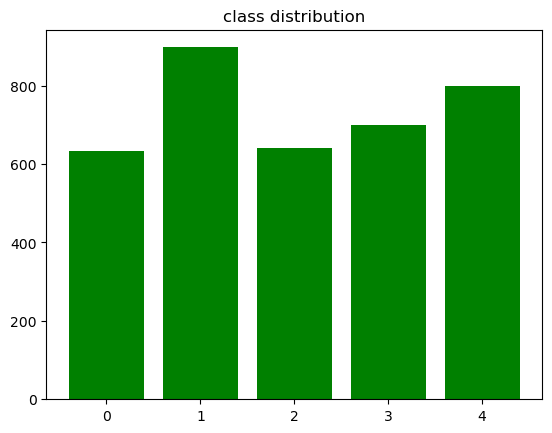

In [7]:
from utils import read_split_data, train_epoch, evaluate
from Mydataset import CustomDataset
from torchvision import transforms
from torch.optim import lr_scheduler
train_data, train_label, val_data, val_label = read_split_data(data_path)

In [8]:
data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]),
    "val": transforms.Compose([transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])}

# instantiate dataset for training and validation
train_dataset = CustomDataset(images_path=train_data,
                          images_class=train_label,
                          transform=data_transform["train"])
val_dataset = CustomDataset(images_path=val_data,
                        images_class=val_label,
                        transform=data_transform["val"])

In [9]:
worker_num = min([os.cpu_count(),batch_size if batch_size>1 else 0, 8])
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=worker_num)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         pin_memory=True,
                                         num_workers=worker_num)

In [10]:
from ViT import ViT as MyViT

model = MyViT(num_classes=num_classes).to(device)

pg = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(pg,lr=learning_rate)

# Cosine annealing learning rate function
lf = lambda x: ((1 + math.cos(x * math.pi / epoch_num )) / 2) * (1 - 0.001) + 0.001  # cosine
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)

In [11]:
for epoch in range(epoch_num):
    train_loss,train_acc = train_epoch(model=model,optimizer=optimizer,data_loader=train_loader,device=device,epoch=epoch)
    scheduler.step()
    val_loss,val_acc = evaluate(model=model,data_loader=val_loader,device=device,epoch=epoch)

[valid epoch 20] loss: 0.829, acc: 0.689: 100%|██████████| 138/138 [00:41<00:00,  3.34it/s]


In [12]:
name = "ViT_pre_train_20_epochs"
torch.save(model.state_dict(),f"./models/{name}.pth")